In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

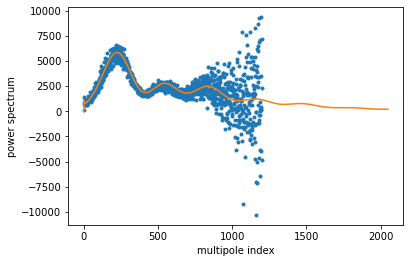

In [83]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pars_old=pars

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 4) 
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ. What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

In [58]:
def ourfun(x,pars):
    #y=a sin(b/(x-c))+d
    y=pars[0]*np.sin(pars[1]/(x-pars[2]))+pars[3]
    return y

def cmbfun(x,pars):
    #call the cmb function with the current parameters
    y = wmap_camb_example.get_spectrum(pars, len(x))[:-2]
    return y

def our_chisq(data,pars):
    #we need a function that calculates chi^2 for us for the MCMC
    #routine to call
    x=data[0]
    y=data[1]
    noise=data[2]
    
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)

        chisq=np.sum( (y-model)**2/noise**2)
    return chisq

In [66]:
# cmb=wmap_camb_example.get_spectrum(pars)

def run_mcmc(pars, data, par_step, chifun, nstep=5000):
    
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    
    chi_cur=chifun(data,pars)
    
    for i in range(nstep):
        
        pars_trial=pars+np.random.randn(npar)*par_step
        chi_trial=chifun(data,pars_trial)
        
        #we now have chi^2 at our current location
        #and chi^2 in our trial location. decide if we take the step
        accept_prob=np.exp(-0.5*(chi_trial-chi_cur))
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars=pars_trial
            chi_cur=chi_trial
        chain[i,:]=pars
        chivec[i]=chi_cur
        
        if i%100==0:
            print("{:.2f} ".format(i/nstep), end = '')
    print("done")
    return chain,chivec

In [91]:
#y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]

x=np.linspace(1,10,1801)
print(len(x), x[-1])

#get starting points with newton's method?

# par_sigs=np.asarray([0.01,0.01,0.01,0.01])
par_sigs=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])/100

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars_guess=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

data=[wmap[:,0], wmap[:,1], wmap[:,2]]

chain,chivec=run_mcmc(pars_guess, data, par_sigs, our_chisq, nstep=2000)

#cut off burn in
pars_sigs_new=np.std(chain,axis=0)
pars_new=np.mean(chain,axis=0)

print(pars_sigs_new)

1801 10.0
0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 done
[2.10754218e+00 6.08999968e-04 5.55351071e-03 3.49493708e-03
 4.40888203e-11 1.26223142e-02]


[7.20744261e+01 2.20729486e-02 1.09788679e-01 5.08527126e-02
 2.00107432e-09 9.57553956e-01]


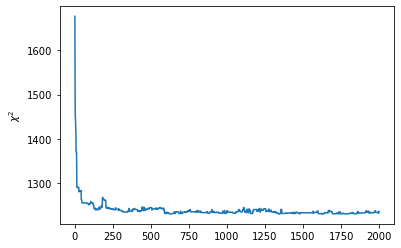

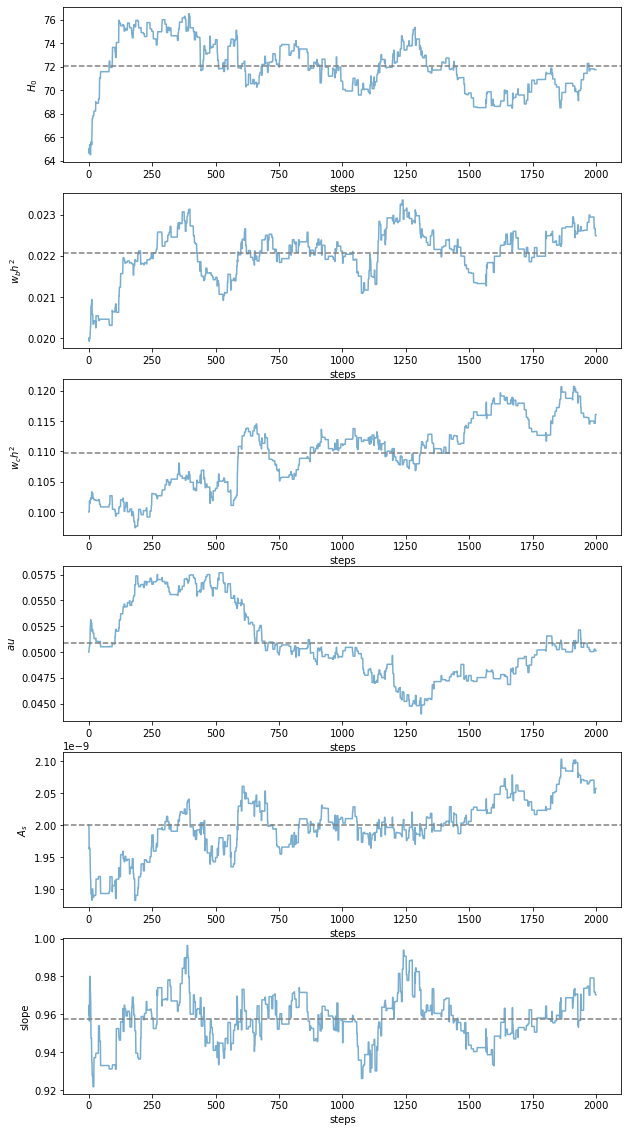

In [101]:
pars_new=np.mean(chain[20:,:], axis=0)
print(pars_new)

variables = ['$H_0$', '$w_bh^2$', '$w_ch^2$', '$\tau$', '$A_s$', 'slope']

paths = np.transpose(chain)

# plt.semilogy(chivec)
plt.plot(chivec)

plt.ylabel("$\chi^2$")
plt.show()

fig, ax = plt.subplots(6, 1, figsize=(10,20))
axs = ax.flatten()

for i, vchain in enumerate(paths):
    axs[i].plot(vchain, alpha=0.6)
#     axs[i].set_title(variables[i])
    axs[i].axhline(pars_new[i], color='grey', ls="--", label="std")
    axs[i].set_xlabel('steps')
    axs[i].set_ylabel(variables[i])

plt.show()

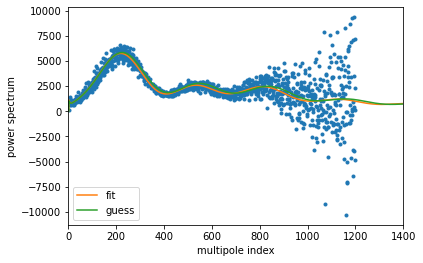

In [102]:
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb_newfit=wmap_camb_example.get_spectrum(pars_new)
cmb_old=wmap_camb_example.get_spectrum(pars_old)

plt.plot(cmb_newfit, label="fit")
plt.plot(cmb_old, label="guess")

plt.xlabel("multipole index")
plt.ylabel("power spectrum")
plt.xlim(0, 1400)
plt.legend()

plt.show()

In [104]:
numChains = 4
allChains = []

for i in range(numChains):
    print("Chain ", i)
    par_sigs=pars_sigs_new

    #[H_0, w_bh2, w_ch2, tau, A_s, slope]
    pars_guess=pars_new+3*par_sigs*np.random.randn(len(pars_guess))
    print("Initial: ", pars_guess)

    chain,chivec=run_mcmc(pars_guess, data, par_sigs, our_chisq, nstep=1000)
    allChains.append(chain)

#     #cut off burn in
#     pars_sigs_new=np.std(chain,axis=0)
#     pars_new=np.mean(chain,axis=0)

Chain  0
Initial:  [7.03912440e+01 2.44604713e-02 1.17714875e-01 5.47085517e-02
 1.78075329e-09 8.98247173e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done
Chain  1
Initial:  [7.08811030e+01 2.21486754e-02 1.02913034e-01 4.37005260e-02
 1.87291989e-09 9.97260404e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done
Chain  2
Initial:  [7.00146239e+01 1.92729271e-02 1.08905689e-01 4.94424995e-02
 2.01385447e-09 9.08538740e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done
Chain  3
Initial:  [7.84082401e+01 2.25223113e-02 1.17697235e-01 7.12906499e-02
 1.92304928e-09 9.33501920e-01]
0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 done


In [ ]:
for i in range(numChains):
    for j in range(i+1, numChains)
    
        #gonna need to do this for each parameter
        #also get rid of burn in
        mean1 = np.mean(allChains[i], axis=0)
        mean2 = np.mean(allChains[j], axis=0)     
        std1 = np.std(allChains[i], axis=0)
        std2 = np.std(allChains[j], axis=0)   
        
        print("diff in sigma: ", (mean1-mean2)/(0.5*(std1-std2)))
        

In [155]:
# https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/
# astrophysics/public/icic/data-analysis-workshop/2018/Convergence-Tests.pdf

means = []
stds = []

allChains = np.array(allChains)

# print(allChains[0])

for i in range(numChains):
    #gonna need to do this for each parameter
    #also get rid of burn in
    meansPara = []
    stdPara = []

#     for k in range(len(pars_new)):
    mean1 = np.mean(allChains[i], axis=0) #might have index wrong here
    std1 = np.std(allChains[i], axis=0)
#     meansPara.append(mean1)
#     stdPara.append(std1)
    
#     print(mean1)
#     print(np.mean(allChains[i][0]))
#     print(np.mean(allChains[i,:,-1]))

    means.append(mean1)
    stds.append(std1)
    
N = len(allChains[0][0])

# print(means)

totalChainMeans = np.mean(means, axis=0) #get right axis here so get array

# print(totalChainMeans)

B = N/(numChains - 1) * np.sum((means - totalChainMeans)**2, axis=0)
W = 1/numChains * np.sum(stds, axis=0)

V = (N-1)/N * W + (numChains+1)/(numChains*N) * B

#should be ~1 for convergence
print(np.sqrt(V/W))

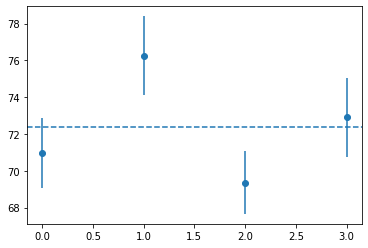

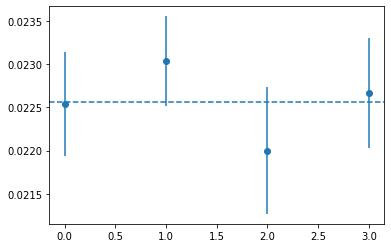

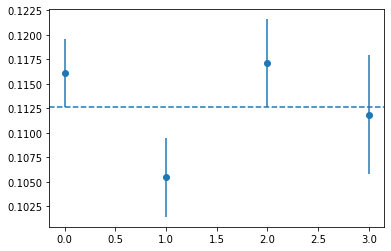

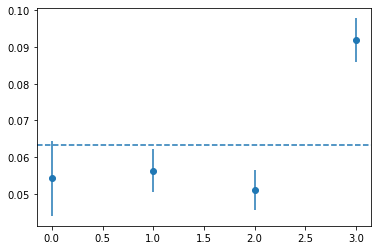

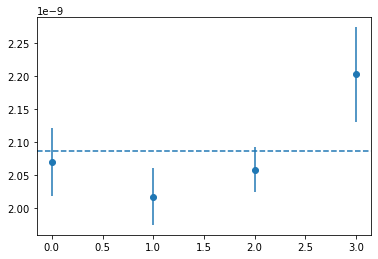

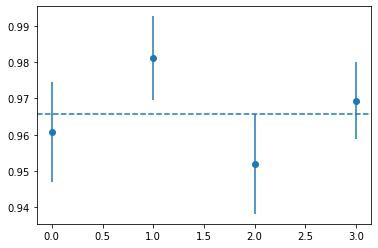

In [169]:
means = np.array(means)
stds = np.array(stds)

for i in range(len(totalChainMeans)):
    
    plt.axhline(totalChainMeans[i], ls="--")
#     plt.fill_between([0, 1, 2, 3], totalChainMeans[i] + )
    plt.errorbar([0, 1, 2, 3], means[:,i], yerr=stds[:,i], marker="o", ls="", )

    plt.show()

What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

In [171]:
coVarMatrix = np.diag(wmap[:,2]**2)

r = np.linalg.cholesky(coVarMatrix);

d = np.dot(r, np.random.randn(r.shape[0]))
print(d)

[-716.0423107    85.92677756  640.83676941 ... 6728.5623138  2493.17674242
 -739.93524535]
